
# Excitable cells as dynamical systems: supplementary lecture

## Preliminary imports

In [1]:
# graphs are incorporated into the notebook 
%pylab inline                 

style.use('ggplot')           # more stylish plots
style.use('seaborn-muted')    # better default line colors

Populating the interactive namespace from numpy and matplotlib


In [2]:
from functools import reduce

In [3]:
from matplotlib import animation

In [4]:
animation.writers.avail

{'avconv': matplotlib.animation.AVConvWriter,
 'avconv_file': matplotlib.animation.AVConvFileWriter,
 'ffmpeg': matplotlib.animation.FFMpegWriter,
 'ffmpeg_file': matplotlib.animation.FFMpegFileWriter,
 'imagemagick': matplotlib.animation.ImageMagickWriter,
 'imagemagick_file': matplotlib.animation.ImageMagickFileWriter}

In [5]:
# division of two integers will return float
#from __future__ import division

In [6]:
# compiled functions for some code speedup
from numba import jit

In [7]:
# spline interpolation for stimulation currents
from scipy.interpolate import UnivariateSpline as usp

##  Defining helper functions to integrade ODEs and set up stimulation protocols

In [8]:
@jit
def boltzman(v,vhalf,k):
    return 1./(1.0 + exp((vhalf-v)/k))

def locmax(v,th=-20):
    "find local maxima higher than threshold"
    allmax = where(diff(sign(diff(v)))<=-1)[0]+1
    allmax = [a for a in allmax if v[a]>=th]
    return array(allmax)

In [9]:
def adams_bashforth(rhs, init_state, dt=0.025, tstart=0, tstop=500,  fnkwargs=None):
    """Simple function to integrate a set of ODEs
    Inputs:
       rhs : callable, calculates right-hand sides of ODEs
       init_state: initial state as a 1D vector
       dt : fixed time step
       tstart: time at start of integration
       tsopt: integrate until this time
       fnkwargs: dictionary with optional parameters for the rhs function
    """
    if fnkwargs is None:
        fnkwargs = {}
        
    ndim = len(init_state)
    tv = arange(tstart,tstop,dt)
    xout = zeros((len(tv), ndim))
    xout[0] = init_state
    fprev = array(rhs(xout[0], tv[0], **fnkwargs))
    xnew = xout[0] + dt*fprev
    xout[1] = xnew
    for k,t in enumerate(tv[1:-1]):
        xprev,xcurr = xout[k:k+2]
        fnew = array(rhs(xcurr, t,**fnkwargs))
        xnew = xcurr + dt*(3*fnew/2.0 - fprev/2.0)
        fprev = fnew
        xout[k+2] = xnew
    return tv, xout

In [10]:
def I_pulse(tx, amp, start, stop,k=10):
    "Creates single pulse with given amplitude, start and stop times"
    return amp*0.5*(1 + tanh(k*(tx-start)) * tanh(k*(-tx+stop)))

def I_ramp(tx, k, start=50,stop=1000):
    "Creates simple linear ramps to use for stimulations"
    #return  k*(tx-start)*I_pulse(tx, 1, start, stop)
    return usp(tx, k*(tx-start)*I_pulse(tx, 1, start, stop),s=0)


def make_pulses(tv, npulses=5, period=5, start=100, amp=5, width=1,steep=10.):
    "Creates a set of pulses for stimulation currents"
    onsets = arange(start, start+npulses*period,period)
    y = np.sum(I_pulse(tv, amp, on, on+width,k=steep) for on in onsets)
    return usp(tv, y, s=0)

def combine_interpolations(tv, signals):
    "Merges several interpolated signals into one interpolation"
    y = np.sum(s(tv) for s in signals)
    return usp(tv, y, s=0)

# currently used object-oriented formulation of the model
# objects of this class are callable, providing the right-hand sides of ODEs
class InapkNeuron:
    def __init__(self, **params):
        self.__dict__.update(params)
        self.I_bias = 0
    def minf(self, v):
        return boltzman(v, self.minf_vhalf, self.minfk)
    def ninf(self, v):
        return boltzman(v, self.ninf_vhalf, self.ninfk)
    def ina(self, v):
        return self.gna*self.minf(v)*(v-self.Ena)
    def ik(self, v, n):
        return self.gk*n*(v-self.Ek)
    def ileak(self,v):
        return self.gl*(v-self.El)
    def vnullcline(self, v, t=0,I_dyn=0):
        I_app = self.I_bias
        if I_dyn:
            I_app += I_dyn(t)
        return (I_app - self.ina(v) - self.ileak(v))/(self.gk*(v-self.Ek))
    def nnullcline(self, v, t=0, I_dyn=0):
        return self.ninf(v)
                                                  
    def __call__(self, state, t, I_dyn=0):
        v,n = state
        I_app = self.I_bias
        if I_dyn:
            I_app += I_dyn(t)
        dV = I_app - (self.ina(v) + self.ileak(v) + self.ik(v,n))
        dn = (self.ninf(v)-n)/self.ntau
        return np.array([dV, dn])

    
# Not used below, but simpler implementation
def inapk_model(state, t, 
                El = -80.0, 
                I_bias = 0,
                I_dyn = 0, 
                Ena = 60.0, 
                Ek = -90.0,
                gl = 8.0,
                gna = 20.0,
                gk = 10.0,
                ntau = 1.0,
                minf_vhalf = -20.,
                minfk = 15.,
                ninf_vhalf = -25.,ninfk = 5.0):
    v,n = state
    minf = boltzman(v, minf_vhalf, minfk)
    ninf = boltzman(v, ninf_vhalf, ninfk)
    dn = (ninf-n)/ntau
    I_app = I_bias #+ I_ramp(t, I_kramp)
    if I_dyn:
        I_app += I_dyn(t)
    dV = I_app - (gna*minf*(v-Ena) + gk*n*(v-Ek) + gl*(v-El))
    return np.array([dV,dn])

### Let's test the stimulation current

(90, 160)

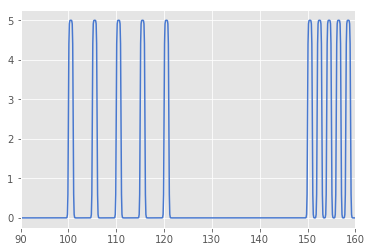

In [11]:
#This is just to test how to make batches of pulses
tx = arange(0,1000,0.1)
Ipulses = make_pulses(tx,npulses=5,period=5,width=1)
Ipulses2 = make_pulses(tx,npulses=5,period=2,width=1,start=150)

Iapp =combine_interpolations(tx, (Ipulses, Ipulses2))

plot(tx, Iapp(tx))
xlim(90,160)

## Setting model parameters

In [12]:
# This set of parameters corresponds to SNIC
napk_pset = dict(
    I_bias = 0.0,
    El = -80.0,
    Ena = 60.0,
    Ek = -90.0,
    gl = 8.0,
    gna = 20.0,
    gk = 10.0,
    ntau = 1.0,
    minf_vhalf = -20.,
    minfk = 15.,
    ninf_vhalf = -25.,
    ninfk = 5.0
)

# Saddle-Node off limit cycle
SN_off = napk_pset.copy()   
SN_off.update(ntau=0.16)

# Supercritical AH (not used)
superAH = napk_pset.copy()  
superAH.update(ninf_vhalf=-44,minf_k=10.)

# Supercritical AH v2 (use this)
superAH2 = napk_pset.copy()
superAH2.update(ninf_vhalf=-44, gl=7, gna=19, ninfk=7, minf_k=10)

# subcritical AH (not used)
subAH = napk_pset.copy()  
subAH.update(gl=1.0, gna=4., gk=4., minf_vhalf=-30.,ninf_vhalf=-40., minfk=7.0)


# subcritical AH (idential to Izhikevich 2007) [use this]
subAH2 = napk_pset.copy()   
subAH2.update(gl=1.0, gna=4., gk=4., minf_vhalf=-30., minfk=7., ninf_vhalf=-45., El=-78.0,)

## Creating model neurons and setting up stimulation currents

In [13]:
snic_neuron = InapkNeuron(**napk_pset)

snoff_neuron = InapkNeuron(**SN_off)
supAH_neuron = InapkNeuron(**superAH)
supAH2_neuron = InapkNeuron(**superAH2) # this one is used

subAH_neuron = InapkNeuron(**subAH)
subAH2_neuron = InapkNeuron(**subAH2)   # this one is used

### Set up some stimulation protocols

In [14]:
Ibias_bif = 4.514
Vrest = -63.8
nrest = boltzman(Vrest, napk_pset['ninf_vhalf'],napk_pset['ninfk'])

#pars = dict(I_bias=4,I_kramp=0.005)

Ipulses = combine_interpolations(tx, 
                                 (make_pulses(tx,amp=10,npulses=10,period=p,start=100+50*k) 
                                  for k,p in enumerate([1.5, 2, 2.5, 3])))

Ipulses2 = combine_interpolations(tx, 
                                 (make_pulses(tx,amp=6,npulses=5,period=p,start=100+(p*5+k*50)) 
                                  for k,p in enumerate([2,  3, 7.4,])))

Ipulses3 = combine_interpolations(tx, [Ipulses2, 
                                       make_pulses(tx, amp=6, start=50,npulses=1),
                                       make_pulses(tx, amp=-6, start=350,npulses=1),
                                       make_pulses(tx, amp=-6, start=300,npulses=1),
                                       make_pulses(tx, amp=6, start=355,npulses=1)])

                                     
pars=dict(I_dyn=Ipulses3) 



## Threshold manifolds

In [15]:
def test_init_state(neuron, state,tstop=100):
    "return the maximum voltage value over a trajectory"
    tvx, outx = adams_bashforth(neuron, state,tstop=tstop)
    return np.max(outx[:,0])

def test_init_state2(neuron, state,tstop=200):
    "return the voltage value range at the end of the trajectory, to test for oscillations"

    tvx, outx = adams_bashforth(neuron, state,tstop=tstop)
    tail = (outx[:,0][tvx>100])
    return amax(tail)-amin(tail)

In [16]:
from functools import reduce

In [17]:
from collections import deque

In [18]:
def prep_phase_portrait(neuron, ax=None):
    if ax is None:
        f,ax = subplots(1,1)
    Vv = arange(-80, 10)
    ax.plot(Vv, neuron.vnullcline(Vv),lw=2,color='#ff6600')
    ax.plot(Vv, neuron.nnullcline(Vv),lw=2,color='#2a7fff')
    setp(ax, ylabel = 'Ik activation', xlabel='membrane potential [mV]')
    ax.axis([-80,10,-0.1,1])
    return ax
    
    

def map_trajectories(neuron, 
                     tstop=100,
                     voltages=linspace(-80,-30,10),
                     activations = linspace(0, 0.5, 10)):
    "Starting from various initial states, plot the trajectories"
    ax = prep_phase_portrait(neuron)
    for v in voltages:
        for n in activations:
            _, traj = adams_bashforth(neuron, array([v,n]), tstop=tstop)
            ax.plot(traj[:,0],traj[:,1], color='k',alpha=0.1)
            ax.plot(traj[0,0],traj[0,1],marker='s',ms=1,mfc='y',mec='y')
            ax.plot(traj[-1,0],traj[-1,1],color='m',marker='.')
    return

from matplotlib import animation

_bitrate=3200
#_writer='avconv'
_writer='ffmpeg'
_fps = 25
_codec = 'libx264'

def animate_phase_portrait(neurons,
                           init_states,
                           video_name,
                           show_step=0.5,
                           time_step=0.025,
                           fnkwargs=None,
                           max_traj_len=500,
                           respawn='rand',
                           nstarts=10,
                           frames = 200,
                           title = '',
                           v_range=(-80,-30),
                           n_range=(0.0,0.5)):
    fig,ax = subplots(1,1,figsize=(6,6))
    ax.set_xlabel('membrane potential [mV]')
    ax.set_ylabel('IK activation')
    ax.set_title(title)
    
    prep_phase_portrait(neurons[0],ax)
    axlims = ax.axis()
    nullclines = ax.lines[:]
    t = [0] 
    states = [[state_] for state_ in init_states]
    points = []
    # print('state:',state)
    for state in states:
        point = ax.plot(state[0][0],state[0][1],color='m',marker='o')
        points.append(point)
    traj_lines = [deque() for s in states]
    def _animate(k):
        #print('state:#2',state)
        if k>0 and not(k%frames):
            if respawn is 'rand':
                new_inits = [array([uniform(*v_range),uniform(*n_range)]) for i_ in range(len(neurons))]
            else:
                new_inits = init_states
            t[0] = 0
            for state, point, init,tjl in zip(states, points, new_inits,traj_lines):
                state[0] = init
                point[-1].set_alpha(0.85)
                point[-1].set_markersize(4)
                point.append(ax.plot(state[0][0],state[0][1],color='m',marker='o')[0])
            while(len(tjl)):
                h = tjl.pop()
                h.set_alpha(0.05)
        # in case of a driven system:
        ax.set_title(title+' %0.2f ms'%t[0])
        Vv = arange(-80, 10)
        
        nullclines[0].set_ydata(neurons[0].vnullcline(Vv,t[0],**fnkwargs))
        nullclines[1].set_ydata(neurons[0].nnullcline(Vv,t[0],**fnkwargs))
        
        for state, neuron, point, tjl in zip(states, neurons,points, traj_lines):
            _,traj = adams_bashforth(neuron,state[0],dt=time_step,
                                     tstart=t[0],tstop=t[0]+show_step,fnkwargs=fnkwargs)
        
            state[0] = traj[-1]
            point[-1].set_data(state[0])
            seg = ax.plot(traj[:,0],traj[:,1],'-',c='k',alpha=1.0)[0]
            for tk,h in enumerate(tjl):
                alpha = h.get_alpha()
                h.set_alpha(max(0.05, alpha*0.95))
            tjl.append(seg)
            if len(tjl)>max_traj_len:
                h = tjl.popleft()
                h.set_visible(0)
                del h
        t[0] += show_step
        ax.axis(axlims)
        sys.stderr.write('\r filming frame %03d, model time: %0.3f ms'%(k,t[0]))
        return reduce(lambda a,b:a+b, traj_lines)
    anim = animation.FuncAnimation(fig, _animate, frames=frames*nstarts, blit=True)
    Writer = animation.writers.avail[_writer]
    w = Writer(fps=_fps,bitrate=_bitrate, codec=_codec )
    anim.save(video_name, writer=w)
    return

In [19]:
from matplotlib import animation
animation.writers.avail

{'avconv': matplotlib.animation.AVConvWriter,
 'avconv_file': matplotlib.animation.AVConvFileWriter,
 'ffmpeg': matplotlib.animation.FFMpegWriter,
 'ffmpeg_file': matplotlib.animation.FFMpegFileWriter,
 'imagemagick': matplotlib.animation.ImageMagickWriter,
 'imagemagick_file': matplotlib.animation.ImageMagickFileWriter}

### near SNIC bifurcation

In [20]:
voltages=linspace(-80,-30,10)
activations =  linspace(0, 0.5, 10)
inits_grid = []
for v in voltages:
    for a in activations:
        inits_grid.append([v,a])

In [21]:
n_neurons = 100
snic_neurons = [InapkNeuron(**napk_pset) for i in range(n_neurons)]
inits = [[uniform(-80,-30),uniform(0,0.5)] for i in range(n_neurons)]

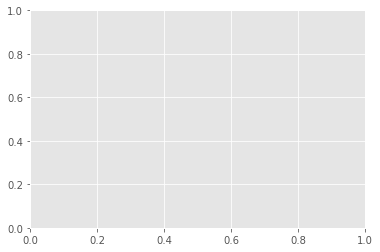

In [22]:
figure()
ax = gca()

 filming frame 049, model time: 5.200 ms

CPU times: user 35.7 s, sys: 116 ms, total: 35.8 s
Wall time: 35.9 s


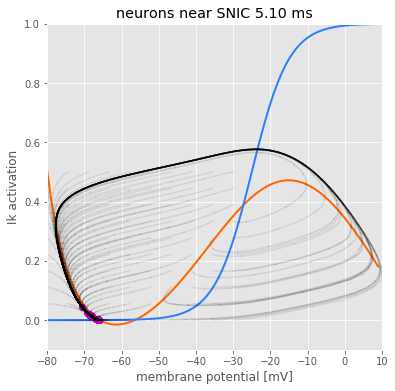

In [27]:
%%time 

animate_phase_portrait(snic_neurons, array(inits_grid),'outputs/snic-multistart2a.mp4',
                       title='neurons near SNIC',
                       frames=50,nstarts=1,show_step=0.1,fnkwargs={})

In [60]:
#animate_phase_portrait(snic_neuron, array([-50,0.02]),'outputs/snic-multistart.mp4',
#                       title='neuron near SNIC',
#                       frames=200,nstarts=50,fnkwargs={})

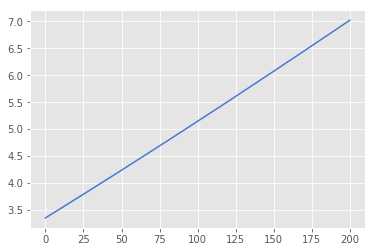

In [27]:
i_ramp = usp(tx,4 + 0.02*(tx-50)*I_pulse(tx, 1, 50, 4000))
plot(tx[tx<200], i_ramp(tx[tx<200]))

 filming frame 1599, model time: 400.500 ms

CPU times: user 5min 49s, sys: 4.04 s, total: 5min 53s
Wall time: 5min 58s


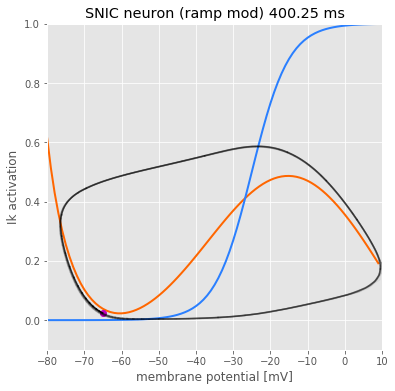

In [94]:
%%time

animate_phase_portrait([snic_neuron], [array([-65,0.02])],'outputs/snic-ramp2.mp4',
                       title='SNIC neuron (ramp mod)',
                       fnkwargs=dict(I_dyn=i_ramp),
                       frames=1600,show_step=0.25,nstarts=1)

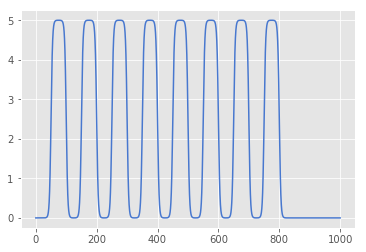

In [23]:
i_stim_slow_modulation = make_pulses(tx, 8, start=50, amp=5, period=100, width=50,steep=0.2)

# this is our slow stimulation protocol
plot(tx, i_stim_slow_modulation(tx))

 filming frame 3999, time:400.200

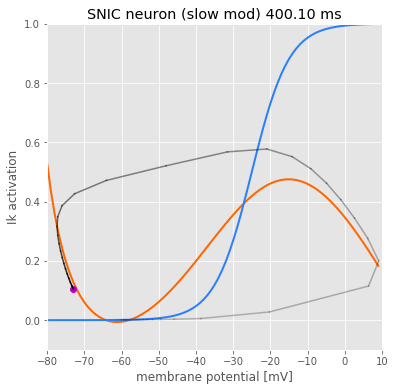

In [158]:
animate_phase_portrait(snic_neuron, array([-50,0.02]),'outputs/snic-slow-modulation.mp4',
                       title='SNIC neuron (slow mod)',
                       fnkwargs=dict(I_dyn=i_stim_slow_modulation),
                       frames=4000,show_step=0.1,nstarts=1)

CPU times: user 5.65 s, sys: 32 ms, total: 5.68 s
Wall time: 5.64 s


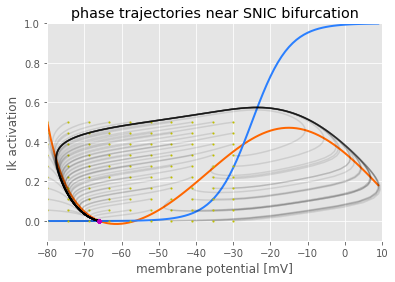

In [49]:
%time map_trajectories(snic_neuron)
title('phase trajectories near SNIC bifurcation')

### near SN off invariant circle bifuraction

In [24]:
snoff_neurons = [InapkNeuron(**SN_off) for i in range(n_neurons)]
for n in snoff_neurons:
    n.I_bias = 4

In [25]:
ioff()

In [26]:
inits = [[uniform(-80,-30),uniform(0,0.5)] for i in range(n_neurons)]

 filming frame 149, model time: 38.000 ms

CPU times: user 6min 14s, sys: 416 ms, total: 6min 14s
Wall time: 6min 14s


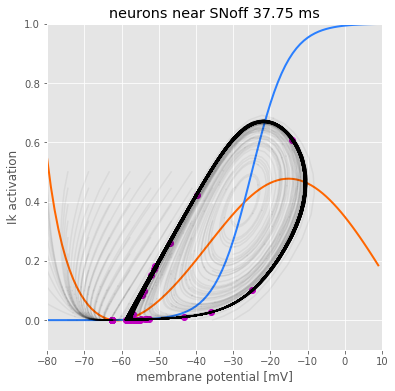

In [28]:
%%time 

animate_phase_portrait(snoff_neurons, array(inits_grid),'outputs/snoff-multistart2-a.mp4',
                       title='neurons near SNoff',
                       frames=150,show_step=0.25,time_step=0.02, nstarts=1,fnkwargs={})

In [39]:
ioff()

 filming frame 399, model time: 100.500 ms

CPU times: user 51.8 s, sys: 675 ms, total: 52.5 s
Wall time: 53 s


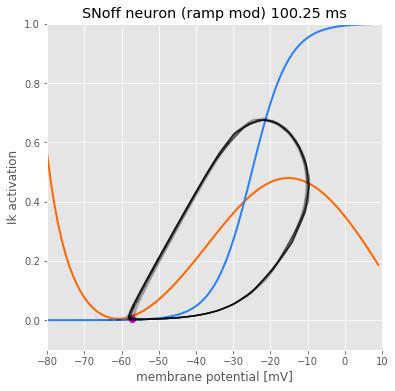

In [73]:
%%time
snoff_neurons[0].I_bias = 0.5
animate_phase_portrait(snoff_neurons[:1], [array([-67,0.02])],'outputs/snoff-ramp2.mp4',
                       title='SNoff neuron (ramp mod)',
                       fnkwargs=dict(I_dyn=i_ramp),
                       frames=400,show_step=0.25,nstarts=1)

CPU times: user 5.26 s, sys: 32 ms, total: 5.3 s
Wall time: 5.27 s


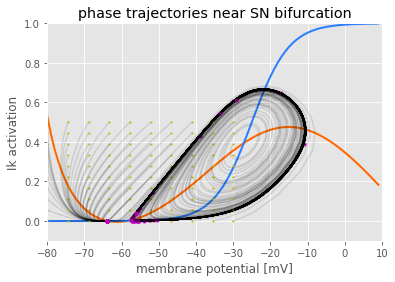

In [48]:
snoff_neuron.I_bias = 3.
%time map_trajectories(snoff_neuron)
title('phase trajectories near SN bifurcation')

### near supercritical AH  bifuraction

In [97]:
supAH2_neurons = [InapkNeuron(**superAH2) for i in range(n_neurons)]
for n in supAH2_neurons:
    n.I_bias = 33

In [98]:
inits = [[uniform(-80,-30),uniform(0,0.5)] for i in range(n_neurons)]

 filming frame 199, model time: 40.400 ms

CPU times: user 14min 46s, sys: 5.34 s, total: 14min 52s
Wall time: 15min 1s


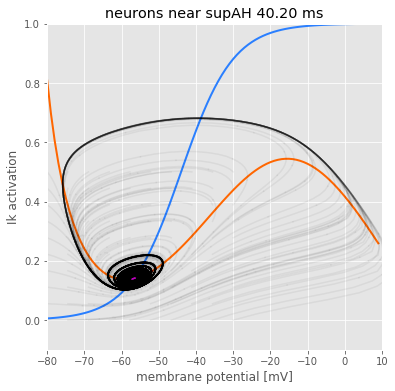

In [99]:
%%time 

animate_phase_portrait(supAH2_neurons, array(inits_grid),'outputs/supah-multistart2.mp4',
                       title='neurons near supAH',
                       frames=200,nstarts=1,show_step=0.2,fnkwargs={})

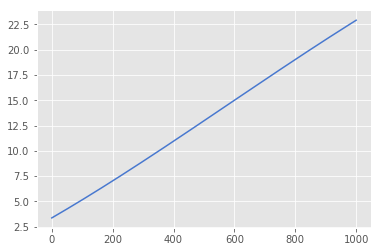

In [47]:
plot(tx,i_ramp(tx))

 filming frame 1999, model time: 1001.000 ms

CPU times: user 7min 8s, sys: 8.09 s, total: 7min 16s
Wall time: 7min 24s


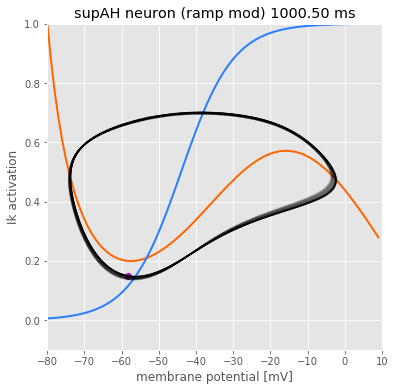

In [56]:
%%time
supAH2_neuron.I_bias = 30
animate_phase_portrait([supAH2_neuron], [array([-60,0.2])],'outputs/supah-ramp2.mp4',
                       title='supAH neuron (ramp mod)',
                       fnkwargs=dict(I_dyn=i_ramp),
                       frames=1600,show_step=0.5,nstarts=1)

CPU times: user 5.53 s, sys: 16 ms, total: 5.55 s
Wall time: 5.53 s


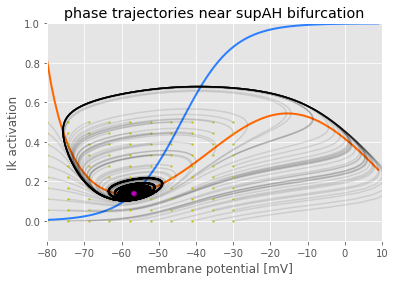

In [50]:
supAH2_neuron.I_bias=33

%time map_trajectories(supAH2_neuron)
title('phase trajectories near supAH bifurcation')

### near subcritical AH  bifuraction

In [51]:
subAH2_neurons = [InapkNeuron(**subAH2) for i in range(n_neurons)]
for n in subAH2_neurons:
    n.I_bias = 43


In [101]:
inits = [[uniform(-80,-30),uniform(0,0.5)] for i in range(n_neurons)]

 filming frame 199, model time: 40.400 ms

CPU times: user 14min 53s, sys: 5.72 s, total: 14min 59s
Wall time: 15min 9s


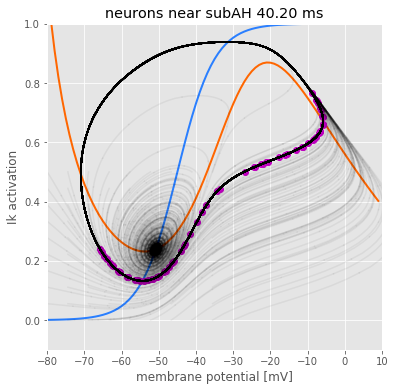

In [102]:
%%time 

animate_phase_portrait(subAH2_neurons, array(inits_grid),'outputs/subah-multistart2a.mp4',
                       title='neurons near subAH',
                       frames=200,show_step=0.2,nstarts=1,fnkwargs={})

 filming frame 399, model time: 402.000 ms

CPU times: user 49.7 s, sys: 652 ms, total: 50.4 s
Wall time: 51.6 s


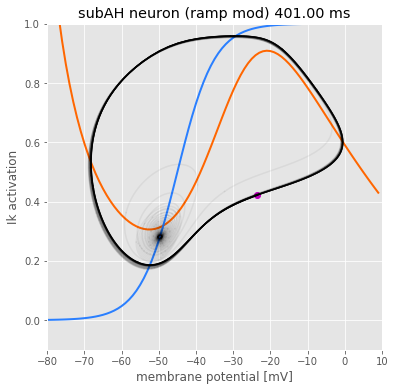

In [89]:
%%time

subAH2_neuron.I_bias=43

animate_phase_portrait([subAH2_neuron], [array([-50,0.2])],'outputs/subah-ramp2.mp4',
                       title='subAH neuron (ramp mod)',
                       fnkwargs=dict(I_dyn=i_ramp),
                       frames=1600,show_step=0.25,nstarts=1)

CPU times: user 5.44 s, sys: 28 ms, total: 5.47 s
Wall time: 5.42 s


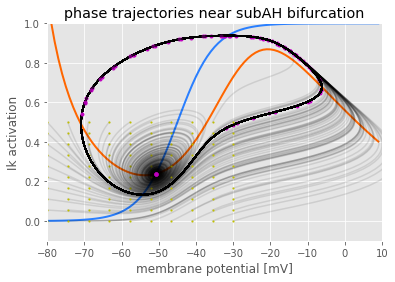

In [52]:
subAH2_neuron.I_bias = 43

%time map_trajectories(subAH2_neuron)

title('phase trajectories near subAH bifurcation')

## Threshold manifolds: excitability

In [29]:
def map_excitability(neuron,    
                     voltages = linspace(-80,-10,50),
                     activations =  linspace(0, 1., 50),
                     cmap='GnBu',
                     testfn=test_init_state2):
    Vmax = np.zeros((len(activations),len(voltages)))
    for i,v in enumerate(voltages):
        for j,n in enumerate(activations):
            state = array([v,n])
            Vmax[j,i] = testfn(neuron, state)
    
    f,ax = subplots(1,1)
    
    if testfn == test_init_state:
        clim=(-65, 10)
    else:
        clim = (0,50)
        
    extent = extent=[voltages[0],voltages[-1],activations[0], activations[-1]]
    m = ax.imshow(Vmax, aspect='auto',extent=extent, clim=clim,cmap=cmap,origin='lower')
    
    prep_phase_portrait(neuron,ax)

    #if testfn == test_init_state:
    colorbar(m)
    
    ylabel('Ik activation')
    xlabel('membrane potential [mV]')
    ax.axis([-80,10,-0.1,1])
    
    return Vmax

In [30]:
voltages = linspace(-80,-30,100)
#sn_activations = linspace(0,0.2,10)
ah_activations = linspace(0,0.8,100)

CPU times: user 6min 49s, sys: 316 ms, total: 6min 50s
Wall time: 6min 49s
CPU times: user 13min 47s, sys: 540 ms, total: 13min 47s
Wall time: 13min 46s


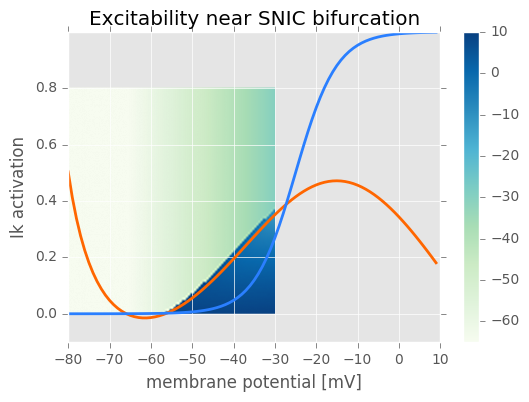

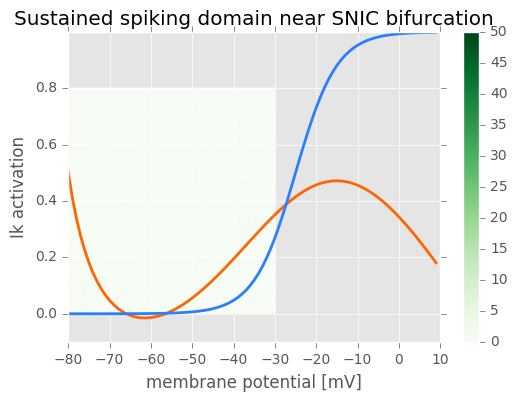

In [25]:
%time Vmax = map_excitability(snic_neuron,voltages=voltages, activations=ah_activations,testfn=test_init_state)
title('Excitability near SNIC bifurcation')

figure()
%time Vmax= map_excitability(snic_neuron,voltages=voltages, activations=ah_activations,  cmap='Greens')
title('Sustained spiking domain near SNIC bifurcation')

CPU times: user 6min 45s, sys: 448 ms, total: 6min 45s
Wall time: 6min 45s
CPU times: user 13min 46s, sys: 640 ms, total: 13min 47s
Wall time: 13min 46s


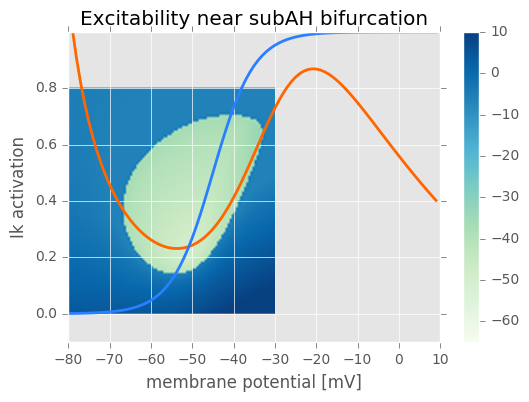

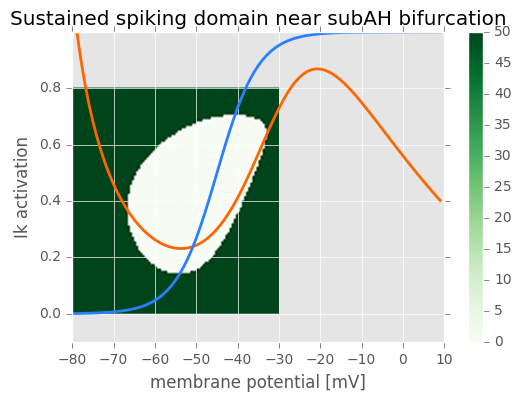

In [26]:
figure()
%time Vmax = map_excitability(subAH2_neuron,voltages=voltages, activations=ah_activations, testfn=test_init_state)
title('Excitability near subAH bifurcation')

figure()
%time Vmax= map_excitability(subAH2_neuron,voltages=voltages, activations=ah_activations,  cmap='Greens')
title('Sustained spiking domain near subAH bifurcation')

CPU times: user 6min 39s, sys: 136 ms, total: 6min 39s
Wall time: 6min 39s
CPU times: user 13min 17s, sys: 600 ms, total: 13min 17s
Wall time: 13min 16s


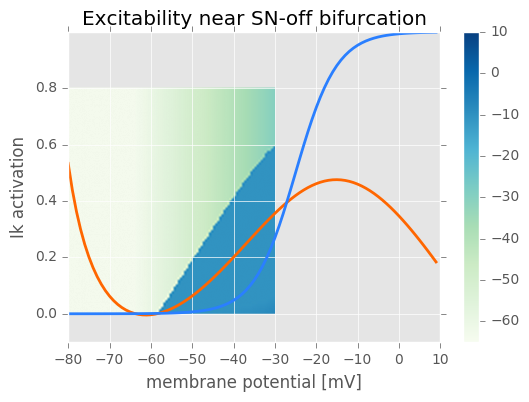

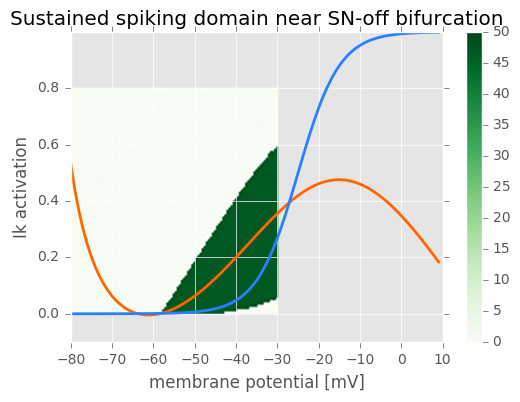

In [27]:
figure()
%time Vmax= map_excitability(snoff_neuron,voltages=voltages, activations=ah_activations,  testfn=test_init_state)
title('Excitability near SN-off bifurcation')

figure()
%time Vmax= map_excitability(snoff_neuron,voltages=voltages, activations=ah_activations,  cmap='Greens')
title('Sustained spiking domain near SN-off bifurcation')

CPU times: user 6min 53s, sys: 404 ms, total: 6min 53s
Wall time: 6min 53s
CPU times: user 14min 2s, sys: 848 ms, total: 14min 3s
Wall time: 14min 2s


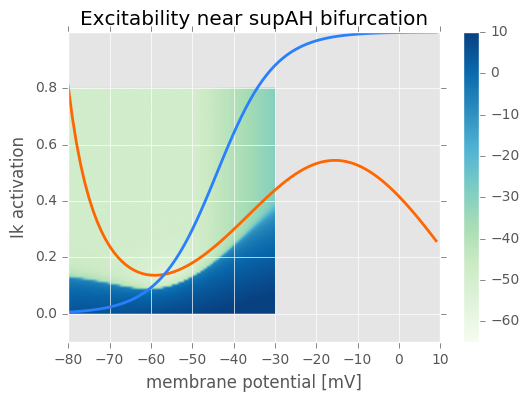

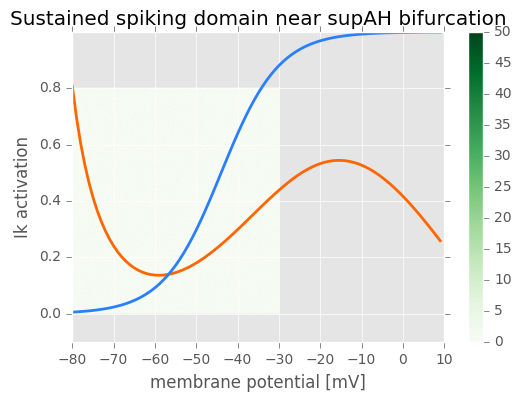

In [28]:

figure()
%time Vmax = map_excitability(supAH2_neuron,voltages=voltages, activations=ah_activations, testfn=test_init_state)
title('Excitability near supAH bifurcation')

figure()
%time Vmax= map_excitability(supAH2_neuron,voltages=voltages, activations=ah_activations,  cmap='Greens')
title('Sustained spiking domain near supAH bifurcation')

----------------

## Response to short pulse batches

In [ ]:
%%time 

init_state = [-63.8, snic_neuron.ninf(-63.8)]
init_state2=[-53.9,  subAH_neuron.ninf(-53.9)]

snic_neuron.I_bias = 3
subAH_neuron.I_bias = 19

tvx, outx = adams_bashforth(snic_neuron, init_state, fnkwargs=pars,tstop=400)
tvx2, outx2 = adams_bashforth(subAH_neuron, init_state2, fnkwargs=pars,tstop=400)

f,axs = subplots(3,1,sharex=True,figsize=(16,9))

axs[0].plot(tvx, outx[:,0],color='orange',label='integrator (SNIC)')
axs[1].plot(tvx2, outx2[:,0],color='royalblue',label='resonator (subAH)')

axs[0].legend(loc='upper left')
axs[1].legend(loc='upper left')


axs[2].plot(tvx2, Ipulses3(tvx2),color='gray',)
#xlim(330,360)
ylim(-6.5, 6.5)
axs[0].set_ylabel('Vm [mv]')
axs[1].set_ylabel('Vm [mv]')

ylabel('Iapp [a.u.]')
xlabel('time [ms]')
#axs[1].set_ylim(-60,-50)
savefig('outputs/integrator-vs-resonator-inapk.svg')
#savefig('outputs/integrator-vs-resonator-inapk.p')

 filming frame 1999, model time: 400.400 ms

CPU times: user 4min 38s, sys: 1.72 s, total: 4min 40s
Wall time: 4min 40s


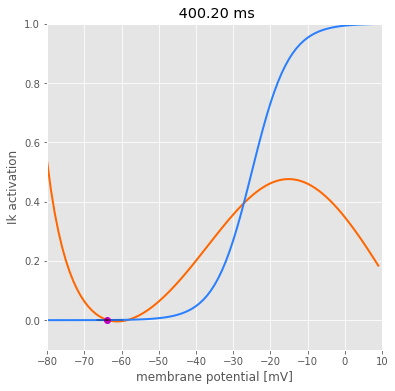

In [32]:
%%time 

animate_phase_portrait([snic_neuron], [init_state],'outputs/snic-pulses-a.mp4',
                       fnkwargs=pars,show_step=0.2,frames=2000,nstarts=1)

 filming frame 1999, model time: 400.400 ms

CPU times: user 4min 34s, sys: 1.57 s, total: 4min 36s
Wall time: 4min 36s


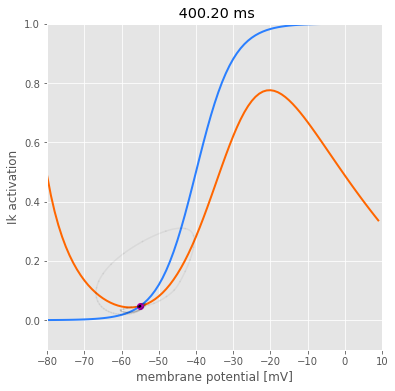

In [36]:
%%time

animate_phase_portrait([subAH_neuron], [init_state2],'outputs/subAH-pulses-a.mp4',
                       fnkwargs=pars,show_step=0.2,time_step=0.01,frames=2000,nstarts=1)

In [45]:
pars

{'I_dyn': <scipy.interpolate.fitpack2.InterpolatedUnivariateSpline at 0x7f9d989ff5f8>}

---------------
## Slow modulation

In [27]:
snic_neuron.I_bias = 0

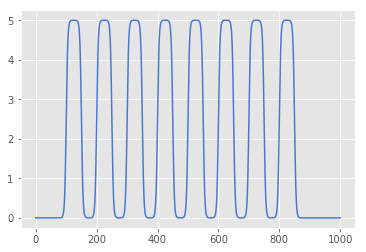

In [118]:
i_stim_slow_modulation = make_pulses(tx, 8, amp=5, period=100, width=50,steep=0.2)

# this is our slow stimulation protocol
plot(tx, i_stim_slow_modulation(tx))

In [120]:
init_state = [-60, 0.01]

In [42]:
def plot_with_i_dyn(neuron, init_tate, stim,tstop=1000,title=""):
    t,traj = adams_bashforth(neuron, init_state, tstop=tstop, fnkwargs=dict(I_dyn=stim))

    figure(figsize=(14,6))

    ax1 = subplot2grid((4,1), (0,0), rowspan=3)
    ax2 = subplot2grid((4,1), (3,0))

    ax1.plot(t, traj[:,0],'royalblue')
    setp(ax1, ylim=(-80,15), xticklabels=[], ylabel='membrane potential [mV]')
    
    ystim = stim(t) + neuron.I_bias
    ax2.plot(t, ystim,'gray')
    
    stim_range = abs(amax(ystim)-amin(ystim))
    ylim = (amin(ystim)-0.1*stim_range, amax(ystim)+0.1*stim_range)
    setp(ax2, ylim=ylim, xlabel='time [ms]', ylabel='I stim [a.u.]')

    ax1.set_title(title)
    #ax1.set_title()

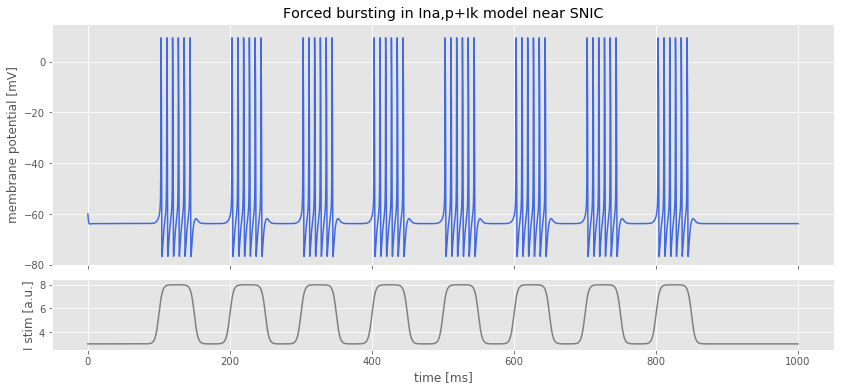

In [122]:
snic_neuron.I_bias=3
plot_with_i_dyn(snic_neuron, init_state, i_stim_slow_modulation, title="Forced bursting in Ina,p+Ik model near SNIC")

[None]

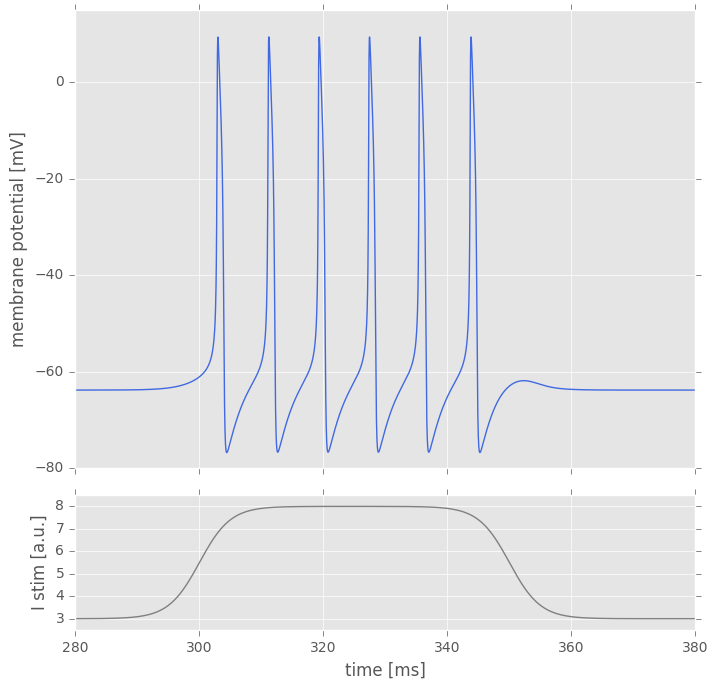

In [41]:
snic_neuron.I_bias=3
plot_with_i_dyn(snic_neuron, init_state, i_stim,title="",tstop=500)
for ax in gcf().axes:
    ax.set_xlim(280,380)
    
for ax in gcf().axes:
    ax.set_xlim(280,380)
    
setp(gcf(), size_inches=(8,8))

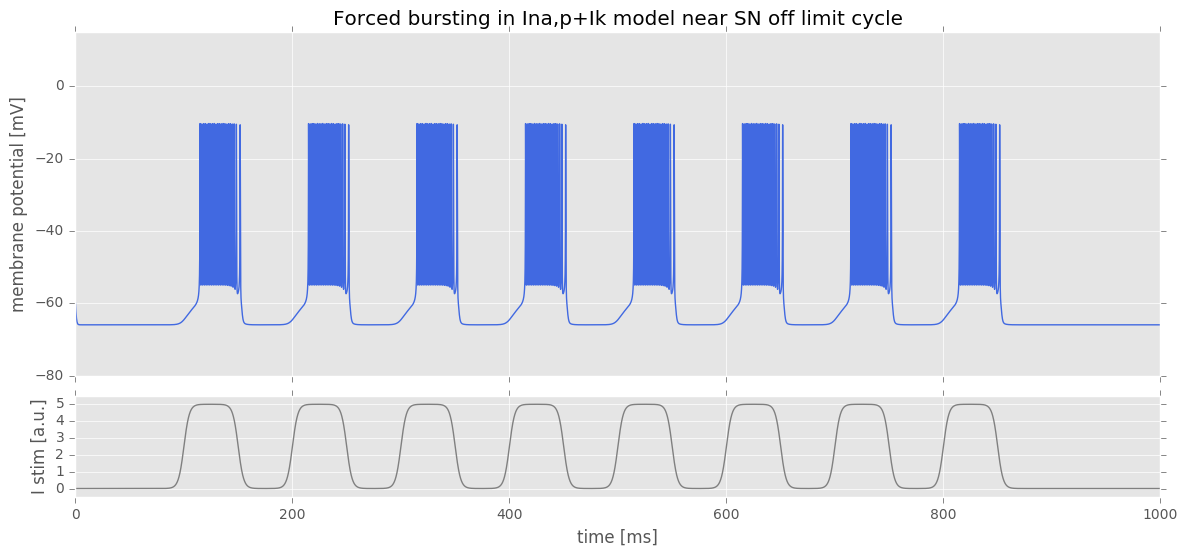

In [42]:
snoff_neuron.I_bias=0
plot_with_i_dyn(snoff_neuron, init_state, i_stim,
                title="Forced bursting in Ina,p+Ik model near SN off limit cycle")

[None]

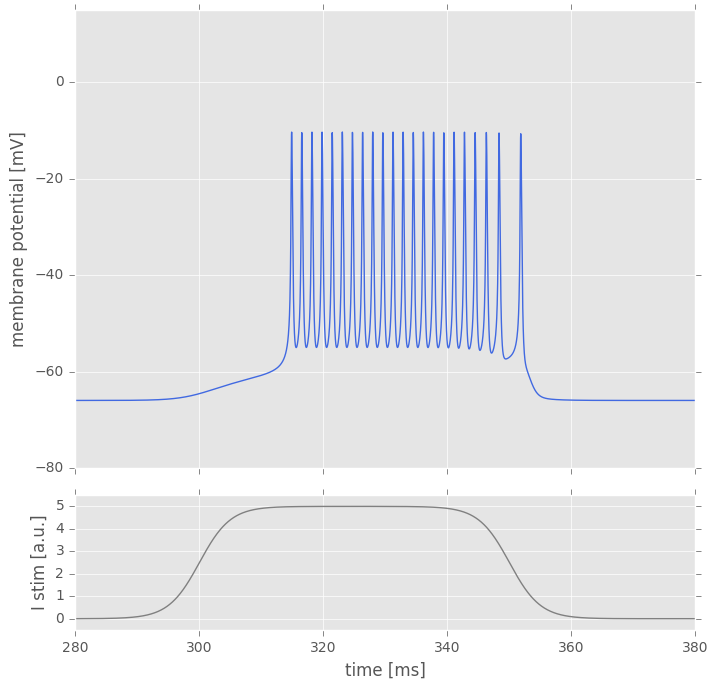

In [43]:
snoff_neuron.I_bias=0
plot_with_i_dyn(snoff_neuron, init_state, i_stim,
                title="")

for ax in gcf().axes:
    ax.set_xlim(280,380)
    
setp(gcf(), size_inches=(8,8))

[-50.80496068   0.23848706]


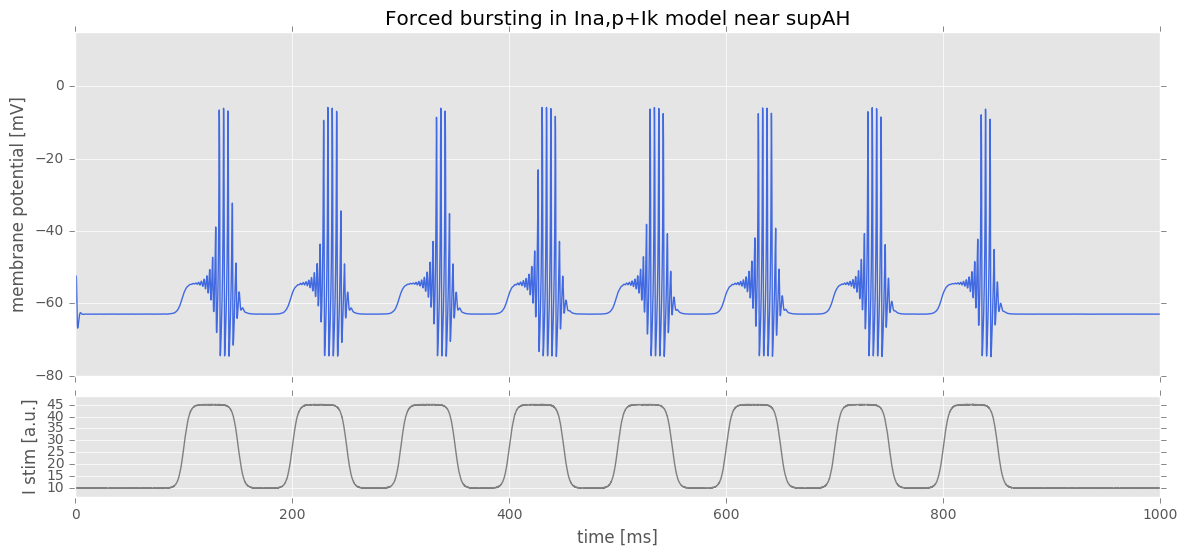

In [44]:
supAH2_neuron.I_bias=10

_,traj = adams_bashforth(subAH2_neuron, [-50.6,0.2459],tstop=200)
init_state_supAH = traj[-1]
print init_state_supAH

plot_with_i_dyn(supAH2_neuron, init_state_supAH, 
                usp(tx,7*i_stim(tx)+0.05*randn(len(tx)),s=0),
                title="Forced bursting in Ina,p+Ik model near supAH")

[None]

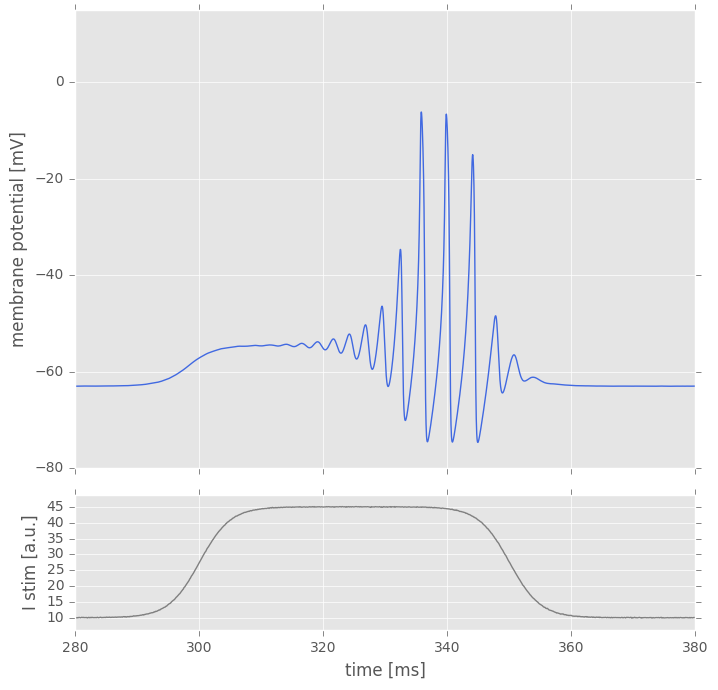

In [45]:
plot_with_i_dyn(supAH2_neuron, init_state_supAH, 
                usp(tx,7*i_stim(tx)+0.05*randn(len(tx)),s=0),
                title="")

for ax in gcf().axes:
    ax.set_xlim(280,380)
    
setp(gcf(), size_inches=(8,8))

[-51.43895255   0.21622702]


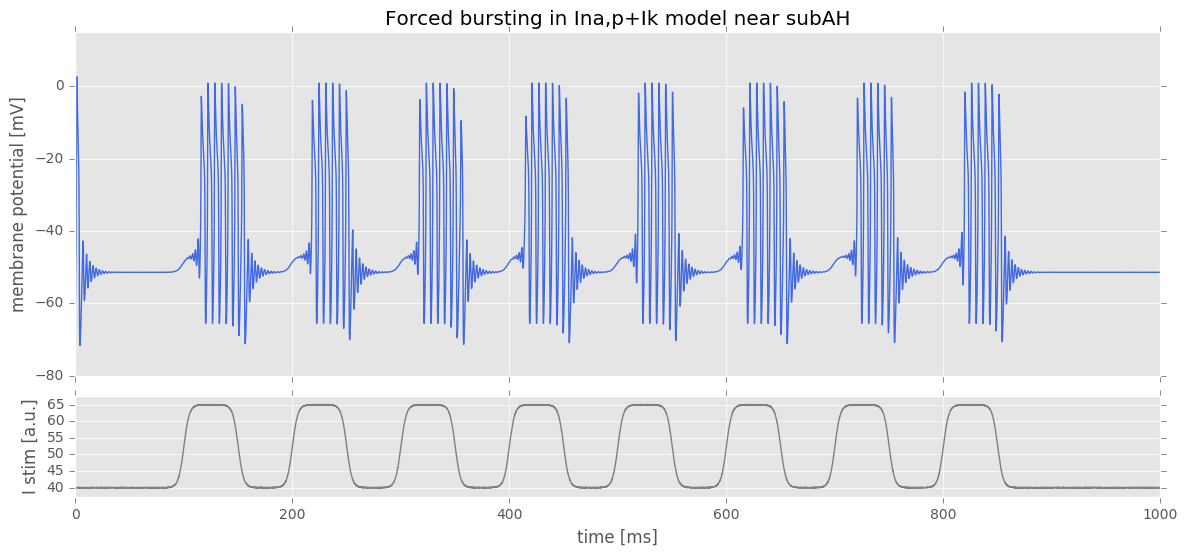

In [46]:
subAH2_neuron.I_bias=40

_,traj = adams_bashforth(subAH2_neuron, [-50.6,0.2459],tstop=200)
init_state_subAH = traj[-1]
print init_state_subAH

plot_with_i_dyn(subAH2_neuron, init_state_subAH, 
                usp(tx,5*i_stim(tx)+0.05*randn(len(tx)),s=0),
                title="Forced bursting in Ina,p+Ik model near subAH")

[None]

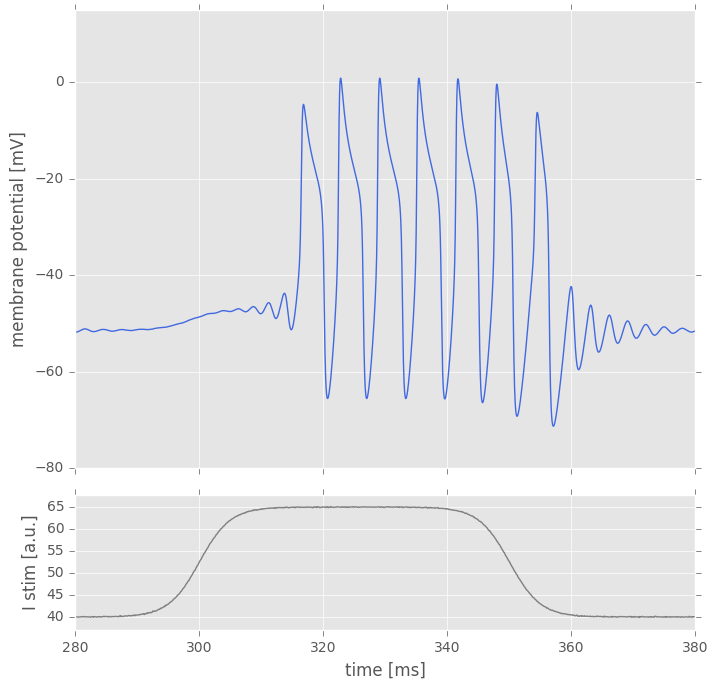

In [47]:
plot_with_i_dyn(subAH2_neuron, init_state_subAH, 
                usp(tx,5*i_stim(tx)+0.05*randn(len(tx)),s=0),
                title="")

for ax in gcf().axes:
    ax.set_xlim(280,380)
    
setp(gcf(), size_inches=(8,8))

------------
## Response to noise

In [40]:
tx = arange(0,100*1000,0.1)
i_stim_noise = usp(tx[::10],randn(len(tx[::10])),s=0)

In [41]:
snoff_neuron.I_bias = 3.9
#snoff_neuron.I_bias = 3.99
_,traj = adams_bashforth(snoff_neuron, init_state,tstop=200)
init_state_snoff = traj[-1]
print (init_state_snoff)

[ -6.27509825e+01   5.25730223e-04]


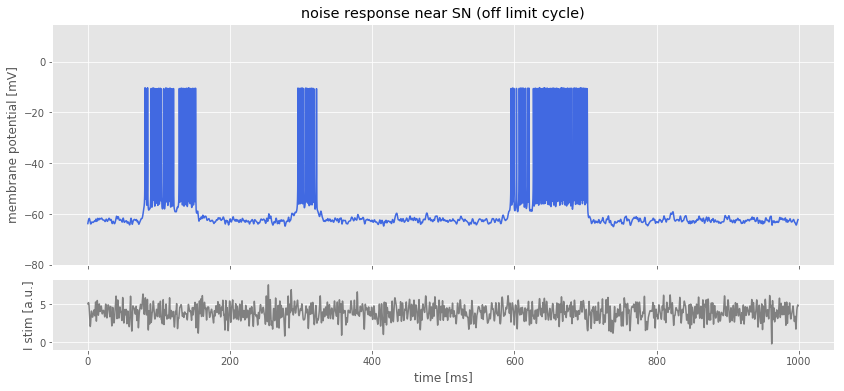

In [43]:
plot_with_i_dyn(snoff_neuron, init_state_snoff, i_stim_noise,tstop=999,
                title='noise response near SN (off limit cycle)')
#gcf().axes[1].set_ylim(2,6)
#for ax in gcf().axes:
#    ax.set_xlim(350,450)


 filming frame 9999, model time: 1000.200 ms

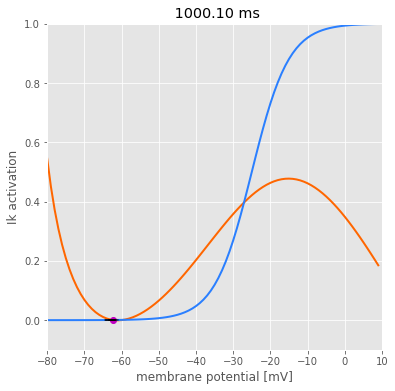

In [50]:
animate_phase_portrait([snoff_neuron], [init_state_snoff],'outputs/snOff-noise-a.mp4',
                       fnkwargs=dict(I_dyn=i_stim_noise),show_step=0.1,time_step=0.01,frames=10000,nstarts=1)

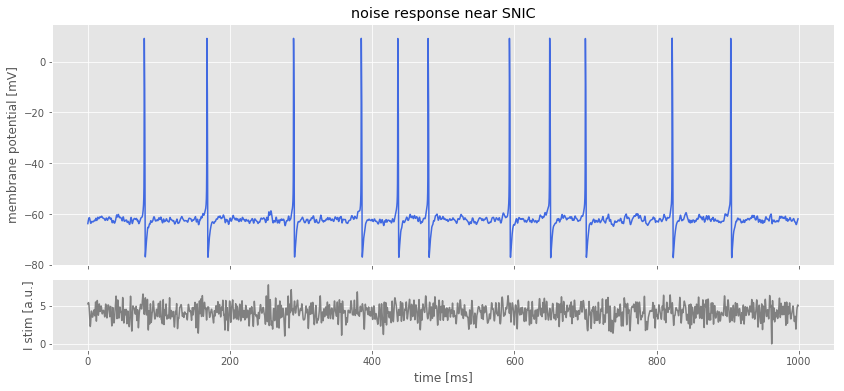

In [47]:
snic_neuron.I_bias=4.1

_,traj = adams_bashforth(snic_neuron, init_state,tstop=200)
init_state_snic = traj[-1]


plot_with_i_dyn(snic_neuron, init_state_snic, i_stim_noise,tstop=999,
                title='noise response near SNIC')
#gcf().axes[1].set_ylim(2,6)

 filming frame 9999, model time: 1000.200 ms

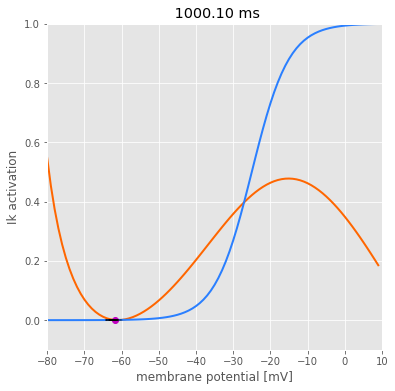

In [51]:
animate_phase_portrait([snic_neuron], [init_state_snic],'outputs/snic-noise-a.mp4',
                       fnkwargs=dict(I_dyn=i_stim_noise),show_step=0.1,time_step=0.02,frames=10000,nstarts=1)

In [52]:
t,traj_long = adams_bashforth(snic_neuron, init_state,tstop=90000, fnkwargs=dict(I_dyn=i_stim_noise))

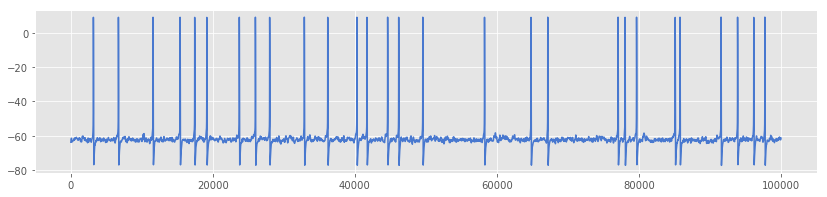

In [70]:
figure(figsize=(14,3))
plot(traj_long[:100000,0])

In [60]:
tv = arange(len(traj_long[:,0]))*0.025

In [62]:
v = traj_long[:,0]
kk = locmax(v)
tlocs = array([tv[k] for k in kk])
isi = diff(tlocs)

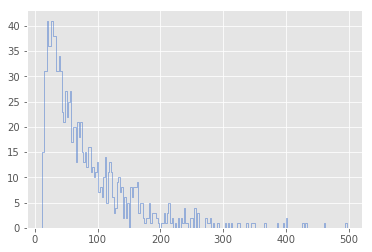

In [76]:
_ = hist(isi, 200, histtype='step')

In [74]:
vnx = array([i_stim_noise(t) for t in tv])

In [75]:
len(tv)

3600000

In [77]:
250*0.025

6.25

In [78]:
sta = array([vnx[k-250:k] for k in kk]).mean(0)

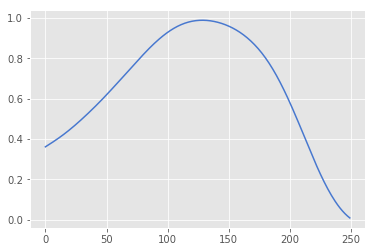

In [79]:
plot(sta)

In [ ]:
subAH_neuron.I_bias=21.2

_,traj = adams_bashforth(subAH_neuron, init_state,tstop=200)
init_state_subAH = traj[-1]
print init_state_subAH

plot_with_i_dyn(subAH_neuron, init_state_subAH, i_stim_noise,tstop=999,
                title='noise response near subAH [?]')
#gcf().axes[1].set_ylim(2,6)

[-50.40666233   0.25325393]


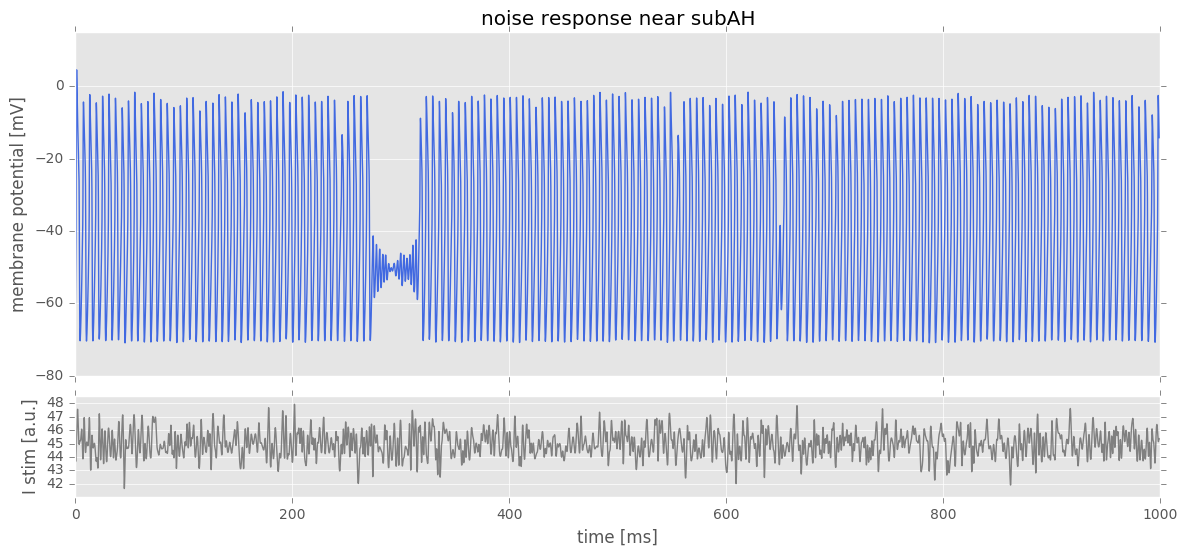

In [80]:
subAH2_neuron.I_bias=45.

_,traj = adams_bashforth(subAH2_neuron, [-50.6,0.2459],tstop=200)
init_state_subAH = traj[-1]
print init_state_subAH

plot_with_i_dyn(subAH2_neuron, init_state_subAH, i_stim_noise,tstop=999,
                title='noise response near subAH')
#gcf().axes[1].set_ylim(2,6)

[-44.17589368   0.22919713]


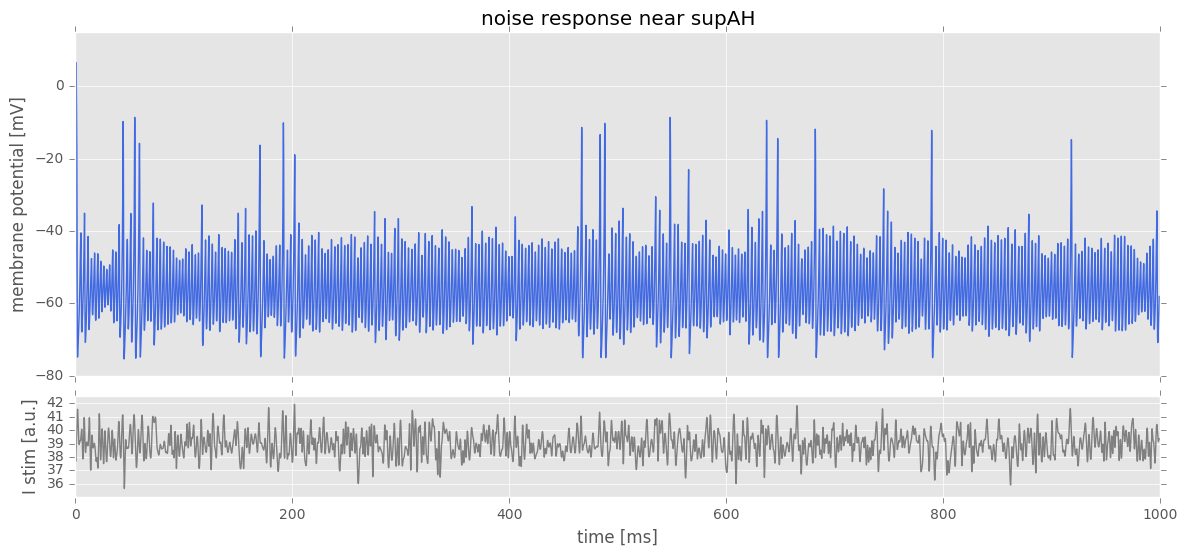

In [82]:
supAH2_neuron.I_bias=39

_,traj = adams_bashforth(supAH2_neuron, init_state,tstop=200)
init_state_supAH = traj[-1]
print init_state_supAH


plot_with_i_dyn(supAH2_neuron, init_state_supAH, i_stim_noise,tstop=999,
                title='noise response near supAH')

--------------
## Response to steps

In [83]:
from imfun import ui

In [84]:
def calc_steps(neuron, modifier = None):
    acc = []
    Vrest = -65
    if modifier is None:
        modifier={}
    iamps = Ibias_bif*1.01 + logspace(0, 6,5,base=2)-1
    
    ib = neuron.I_bias
    neuron.I_bias = 0
    

    for iamp in iamps:
        #print iamp
        Iapp = usp(tx, I_pulse(tx, iamp, 50, 550),s=0)
        pars = dict(I_dyn=Iapp)
        nrest = neuron.ninf(Vrest)
        st_init = array([Vrest, nrest])
        tvx, outx = adams_bashforth(neuron, st_init, fnkwargs=pars, tstop=600)
        acc.append(outx[:,0])
    
    neuron.I_bias = ib
    return tvx,array(acc),iamps

    
               

In [85]:
tvx,resp_1,iamps = calc_steps(snic_neuron)
tvx,resp_2,iamsp = calc_steps(supAH_neuron)

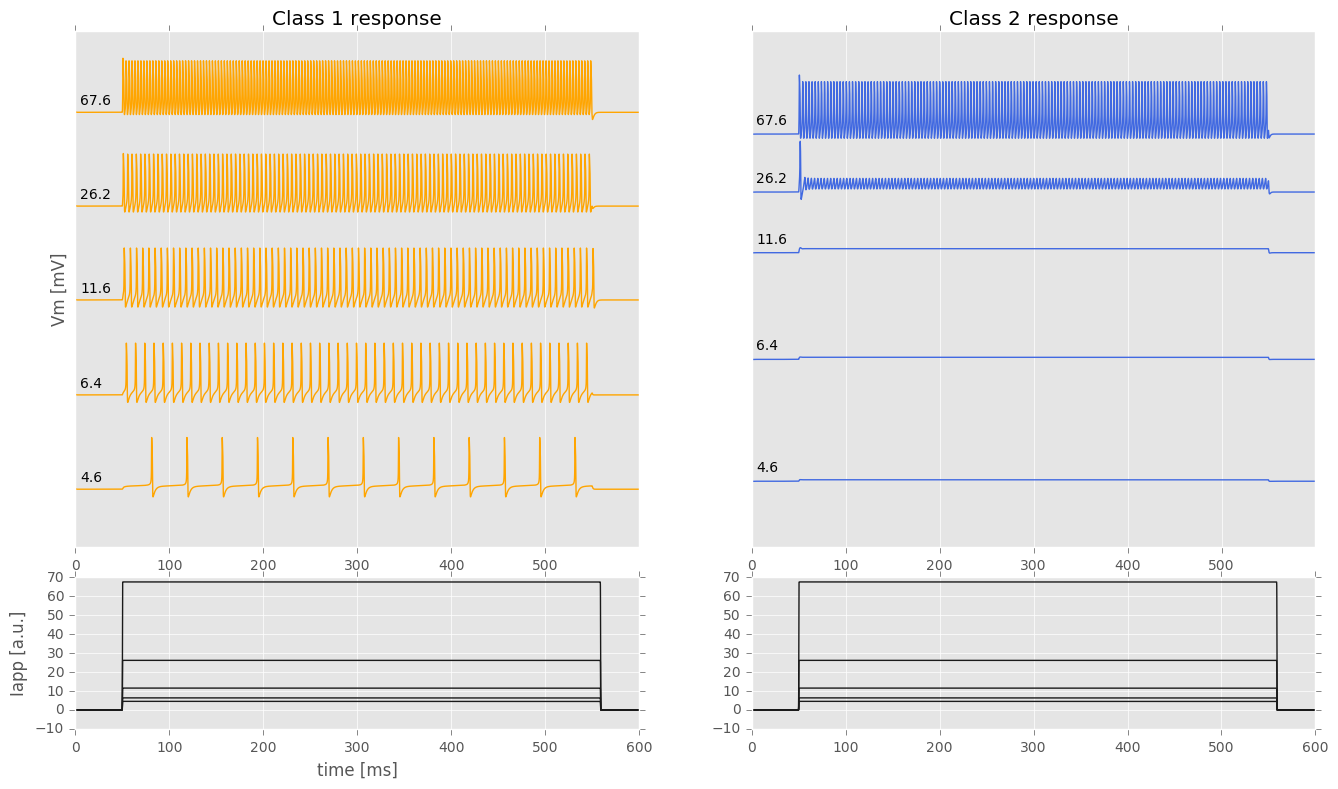

In [86]:
#f, axs = subplots(2,1,sharex=True,figsize=(16,12))

figure(figsize=(16,9))
ax1 = plt.subplot2grid((4,2), (0,0), rowspan=3)
ax2 = plt.subplot2grid((4,2),(3,0),)

ax3 = plt.subplot2grid((4,2), (0,1), rowspan=3)
ax4 = plt.subplot2grid((4,2),(3,1),)


labels=['%1.1f'%i for i in iamps]

ui.plot_coll(resp_1[::-1], x=tvx,ax=ax1,frame_on=True,colors='orange',sep=50)
ui.plot_coll(resp_2[::-1], x=tvx,ax=ax3,frame_on=True,colors='royalblue',sep=70)

setp(ax1, ylim = (-150, 600), ylabel='Vm [mV]', title='Class 1 response')
setp(ax3, ylim = (-150, 500), title='Class 2 response')

setp(ax2, xlabel='time [ms]', ylabel = 'Iapp [a.u.]')

#ax1.legend()

for line,label in zip(ax1.lines,labels[::-1]):
    yl = line.get_ydata()[0]
    ax1.text(5, yl+10, label)

for line,label in zip(ax3.lines,labels[::-1]):
    yl = line.get_ydata()[0]
    ax3.text(5, yl+10, label)
    

for i in iamps:
    y = usp(tx, I_pulse(tx, i, 50, 559),s=0)
    
    ax2.plot(tvx, y(tvx),color=(0.1,0.1,0.1))
    ax4.plot(tvx, y(tvx),color=(0.1,0.1,0.1))
#ylim(-1,55)

savefig('outputs/class1-2-responses-inapk.png')
savefig('outputs/class1-2-responses-inapk.svg')

In [87]:
def find_spiking_freq(neuron,Iv,T_cut = 500):
    acc = []
    _,traj = adams_bashforth(neuron, [-60,0.5], tstop=100)
    init_state = traj[-1]
    ib = neuron.I_bias
    for i in Iv:
        neuron.I_bias = i
        tvx_, outx_ = adams_bashforth(neuron, init_state,tstop=1000)
        v = outx_[:,0]
        kk = locmax(v)
        tlocs = array([tvx_[k] for k in kk])
        
        if len(tlocs) and any(tlocs>T_cut):
            ff = 1000./mean(diff(tlocs[tlocs>T_cut]))
        else:
            ff = 0
        #print i, len(tlocs), min(tlocs),max(tlocs)
        acc.append(ff)
    neuron.I_bias = ib
    return array(acc)
    

In [88]:
tx = linspace(0,1000,200)
Iv = 4 + 0.005*(tx-50)*I_pulse(tx, 1, 50, 4000)
%time ffv = find_spiking_freq(snic_neuron, Iv)

CPU times: user 2min 6s, sys: 40 ms, total: 2min 6s
Wall time: 2min 6s


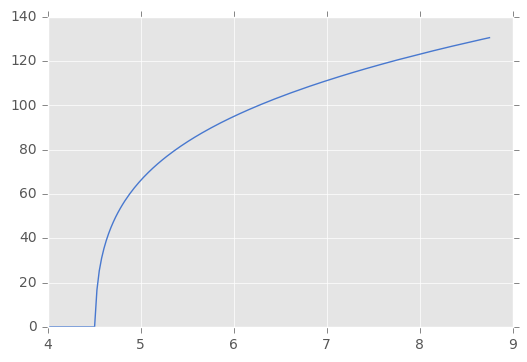

In [89]:
plot(Iv, ffv)

In [90]:
snic_neuron.I_bias = 0

(0, 150)

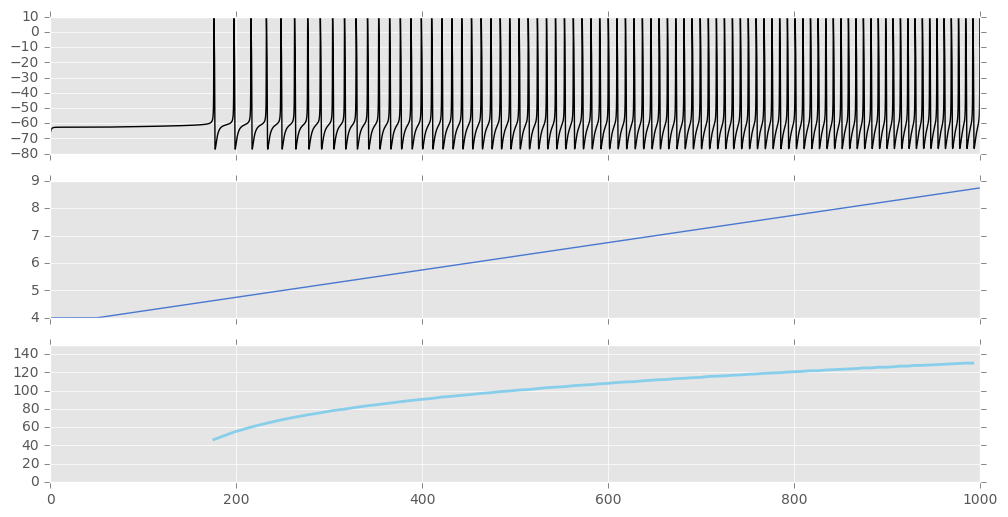

In [91]:
f, axs = subplots(3,1,figsize=(12,6), sharex=True)


tvx, outx = adams_bashforth(snic_neuron, [-65, 0.5],tstop=100)
init_state = outx[-1]

tvx, outx = adams_bashforth(snic_neuron, init_state, tstop=1000, fnkwargs=dict(I_dyn=usp(tx, Iv,s=0)))

V = outx[:,0]
axs[0].plot(tvx, V, color='black')
axs[1].plot(tx,Iv)

tlocs = [tvx[k] for k in locmax(V)]
ffv2 = 1000./diff(tlocs)


axs[2].plot(tlocs[:-1], ffv2,'-',color='skyblue',lw=2)
ylim(0,150)

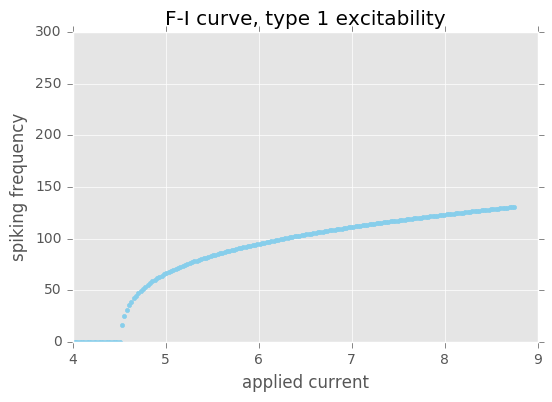

In [92]:
plot(Iv, ffv,'.',color='skyblue',)
#axs[2].plot(tlocs[:-1], ffv2,'.',color='skyblue',)
ylim(0,300)
xlabel('applied current')
ylabel('spiking frequency')
title("F-I curve, type 1 excitability")
savefig('outputs/F-I_curve_class1-inapk.svg')

In [93]:
#pars = dict(I_bias=6,I_kramp=0.05)

Iv2 = 4 + 0.05*(tx-10)*I_pulse(tx, 1, 10, 4000)

supAH_neuron.I_bias = 0

stim = usp(tx, Iv2+0.05*randn(len(tx)),s=0)

tvx1, outx1 = adams_bashforth(snic_neuron, init_state, fnkwargs=dict(I_dyn=stim),tstop=1000)
tvx2, outx2 = adams_bashforth(supAH_neuron, init_state, fnkwargs=dict(I_dyn=stim),tstop=1000)

90


(0, 300)

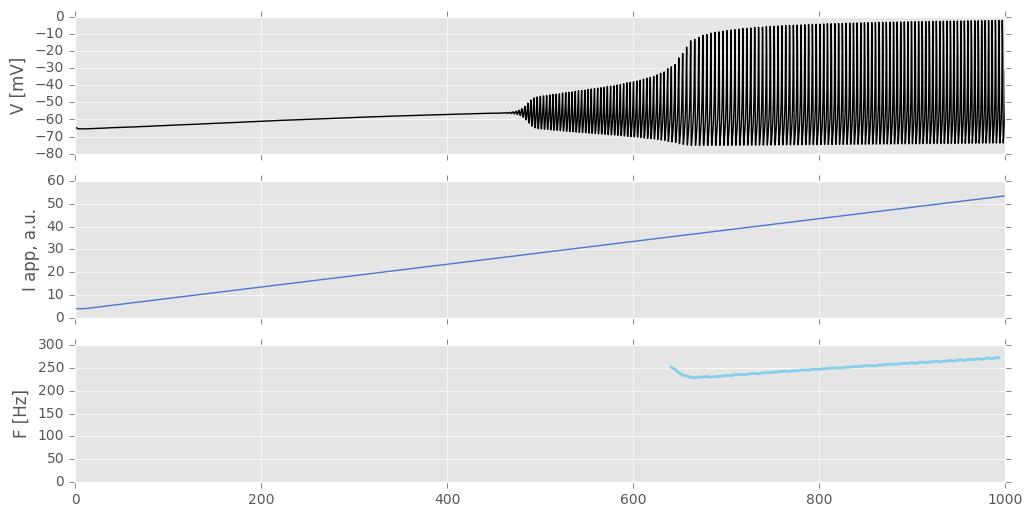

In [94]:
f, axs = subplots(3,1,figsize=(12,6), sharex=True)

V = outx2[:,0]
axs[0].plot(tvx2, V, color='black')
axs[1].plot(tx,Iv2)

axs[0].set_ylabel('V [mV]')
axs[1].set_ylabel('I app, a.u.')
axs[2].set_ylabel('F [Hz]')



tlocs = [tvx2[k] for k in locmax(V,-30)]
print len(tlocs)
ffvx = 1000./diff(tlocs)


axs[2].plot(tlocs[:-1], ffvx,'-',color='skyblue',lw=2)
ylim(0,300)

In [95]:
%time ffv2 = find_spiking_freq(supAH_neuron, Iv2)
%time ffv3 = find_spiking_freq(snic_neuron, Iv2)

CPU times: user 1min 57s, sys: 32 ms, total: 1min 57s
Wall time: 1min 57s
CPU times: user 1min 57s, sys: 248 ms, total: 1min 57s
Wall time: 1min 58s


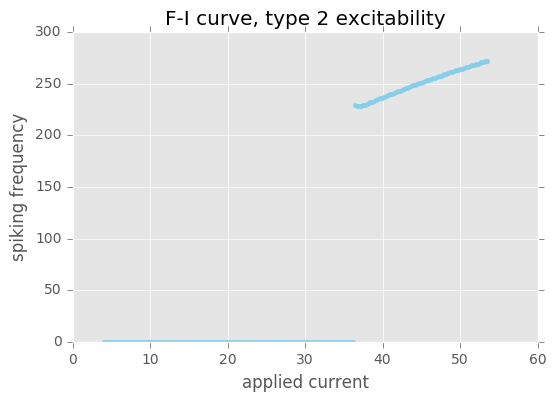

In [96]:
plot(Iv2, ffv2,'.',color='skyblue',)
#axs[2].plot(tlocs[:-1], ffv2,'.',color='skyblue',)
ylim(0,300)
xlabel('applied current')
ylabel('spiking frequency')
title("F-I curve, type 2 excitability")
savefig('outputs/F-I_curve_class2-inapk.svg')

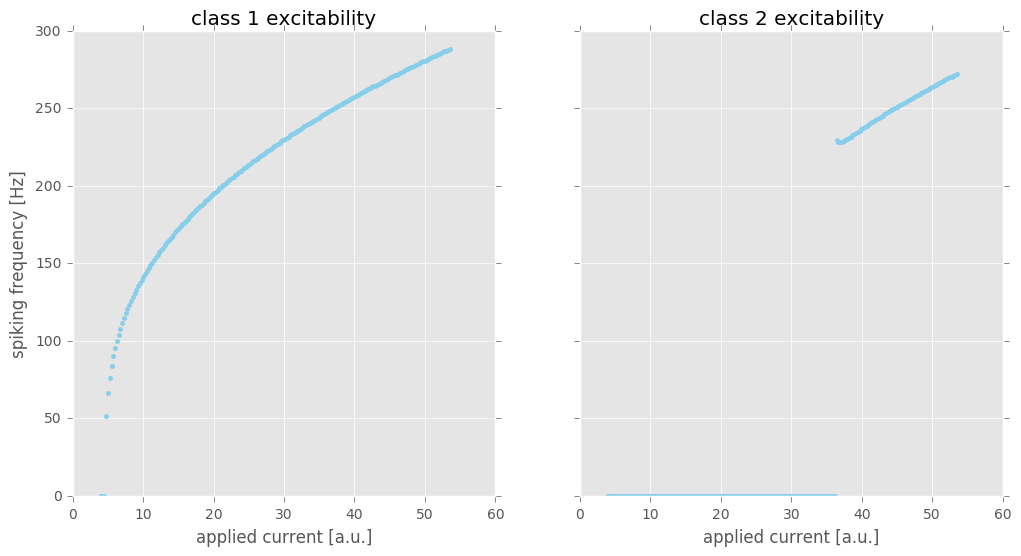

In [97]:
f, axs = subplots(1,2,sharey=True,sharex=True,figsize=(12,6))

axs[0].plot(Iv2, ffv3,'.',color='skyblue',)
axs[1].plot(Iv2, ffv2,'.',color='skyblue',)
#axs[2].plot(tlocs[:-1], ffv2,'.',color='skyblue',)
ylim(0,300)
axs[0].set_xlabel('applied current [a.u.]')
axs[1].set_xlabel('applied current [a.u.]')

axs[0].set_ylabel('spiking frequency [Hz]')
axs[0].set_title("class 1 excitability")
axs[1].set_title("class 2 excitability")
savefig('outputs/F-I_curves_both-inapk.svg')